# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
bikes_df_raw = pd.read_csv("data/BSS_hour_raw.csv")
print(bikes_df_raw.dtypes)
bikes_df_raw.describe()


dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


*Answer:* In general, the means and ranges of variables seem to make sense. But perhaps the max value of registered riders at 886 riders per hour may seem quite high, especially considering that the mean is 153.78 riders. Still, since casual riders also appears to have a much higher max value than its mean, this skewing does not point to anything irregular in the data.

The data types all seem to make sense, since all variables excluding the normalized temperature, humidity, and windspeed metrics are integer values. As noted in the next part of the problem set, the DTE variable is an object, rather than an int, float, or other numeric datatype. 

**1.2 Notice that the variable in column...**

In [4]:
test = bikes_df_raw[['dteday']]
test.dtypes

dteday    object
dtype: object

In [5]:
bikes_df_raw["dteday"] = pd.to_datetime(bikes_df_raw["dteday"])
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3 Create three new columns in the dataframe:...**

In [6]:
#https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column
bikes_df_raw["year"] = bikes_df_raw["dteday"].map(lambda x: x.year - 2011)
bikes_df_raw["month"] = bikes_df_raw["dteday"].map(lambda x: x.month)
bikes_df_raw["counts"] = bikes_df_raw["casual"] + bikes_df_raw["registered"]
bikes_df_raw.describe()


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,0.502561,6.537775,189.463088
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,0.500008,3.438776,181.387599
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,0.000000,4.000000,40.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,1.000000,7.000000,142.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,1.000000,10.000000,281.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,1.000000,12.000000,977.000000


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

Text(0.5, 0, 'Saturday')

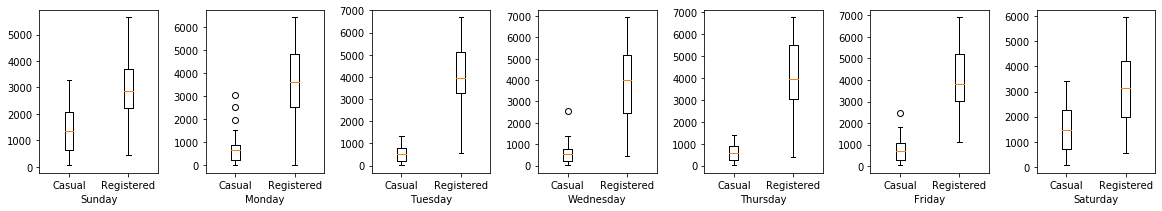

In [7]:
#bikes_by_day = bikes_df_raw[["dteday", "weekday", "weather", "season", "temp", "atemp", "windspeed", "hum"]].copy()
#https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
bikes_by_day = bikes_df_raw.groupby("dteday", as_index=False).agg({"weekday" : 'max', "weather" : 'max', 
                                                   "season" : 'max', "temp" : 'mean', "atemp" : 'mean', 
                                                   "windspeed" : 'mean', "hum" : 'mean', "casual": 'sum', 
                                                   "registered": 'sum', "counts" : 'sum'})
'''
fig, ax = plt.subplots(1,1)
ax.scatter(bikes_by_day["weekday"], bikes_by_day["casual"])
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Riders')
ax.set_title('Number of Riders by Day of the Week')
ax.grid(True)
'''
#bikes_by_day.groupby("weekday").filter(lambda)

casual_lst = []
for i in range(0,7):
    casual_lst.append(bikes_by_day[bikes_by_day["weekday"]==i]["casual"])

registered_lst = []
for i in range(0,7):
    registered_lst.append(bikes_by_day[bikes_by_day["weekday"]==i]["registered"])

fig, ax = plt.subplots(1,7, figsize=(20,3))
plt.subplots_adjust(wspace = 0.4)

for i in range(0,7):
    ax[i].boxplot([casual_lst[i], registered_lst[i]])
    ax[i].set_xticklabels(["Casual", "Registered"])

ax[0].set_xlabel("Sunday")
ax[1].set_xlabel("Monday")
ax[2].set_xlabel("Tuesday")
ax[3].set_xlabel("Wednesday")
ax[4].set_xlabel("Thursday")
ax[5].set_xlabel("Friday")
ax[6].set_xlabel("Saturday")

**2.2 Use `bikes_by_day` to visualize how the distribution...**

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
441,2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836
667,2012-10-29,1,3,4,0.440000,0.439400,0.358200,0.880000,2,20,22


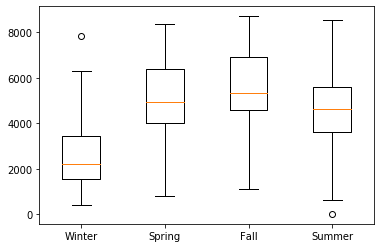

In [8]:
season_lst = []
for i in range(1,5):
    season_lst.append(bikes_by_day[bikes_by_day["season"]==i]["counts"])
    
fig, ax = plt.subplots(1,1)
ax.boxplot(season_lst)
ax.set_xticklabels(["Winter", "Spring", "Fall", "Summer"])

bikes_by_day[((bikes_by_day["season"] == 1) & (bikes_by_day["counts"] > 7500)) |
             ((bikes_by_day["season"] == 4) & (bikes_by_day["counts"] < 100))]

*Answer:* Yes, there appears to be outliers. 

For the March 17, 2012 outlier, high ridership can possibly be explained because it is a holiday, St. Patrick's Day, and it falls on a weekend with relatively decent weather. 

For the October 29, 2012 outlier, the low ridership can be possibly explained because Hurricane Sandy reached landfall on New Jersey on that day.

**2.3 Convert the categorical attributes...**

In [9]:
type(bikes_df_raw['month'])

pandas.core.series.Series

In [10]:
bikes_df = bikes_df_raw.copy()

def onehot(df, column):
    for i in range((df[column].min() + 1), (df[column].max()+1)):
        df['{}{}'.format(column, i)] = (df[column] == i).astype(int)
    return df

onehot_cols = ['season', 'month', 'weekday', 'weather']
for col in onehot_cols:
    bikes_df = onehot(bikes_df, col)

#bikes_df = bikes_df.drop(onehot_cols, axis=1)

pd.set_option('display.max_columns', None)
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts,season2,season3,season4,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,weather2,weather3,weather4
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [11]:
bikes_train, bikes_test = train_test_split(bikes_df, train_size=0.5, random_state=90, stratify=bikes_df[['month']])

**2.5 Although we asked you to create your train and test set...**

In [12]:
BSS_train = pd.read_csv('data/BSS_train.csv').drop('dteday', axis=1)
BSS_test = pd.read_csv('data/BSS_test.csv').drop('dteday', axis=1)

**2.6 Use pandas' `scatter_matrix` command to visualize...**

In [13]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed', 'counts', 'casual', 'registered', 'fall', 'summer', 'spring', 'Snow', 'Storm', 'Cloudy']

#pd.plotting.scatter_matrix(BSS_train[cor_columns], figsize=(16, 16))

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

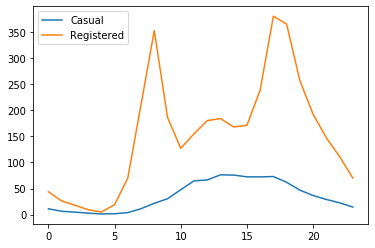

In [14]:
plt_hr = BSS_train.groupby("hour", as_index=False).agg({'casual' : 'mean', 'registered' : 'mean'})

fig, ax = plt.subplots(1,1)
ax.plot(plt_hr['hour'], plt_hr['casual'], label='Casual')
ax.plot(plt_hr['hour'], plt_hr['registered'], label='Registered')
ax.legend()

*Answer:* Usage for registered riders speaks during commuting hours, around 8-9 AM and 5 PM-7 PM, and steeply decline during the late evenings and early mornings.

In contrast, casual riders steadily rise in usage throughout the morning until plateau-ing in usage rates between 10 AM and 5 PM. In otherwords, casual riders tend to use bikes more often during work hours, while registered users tend to use them most often right before or after working hours.

Additionally, the number of registered riders exceeds casual riders at all hours by large margins. 

**2.8 Use the weather related variables to show how each weather...** 

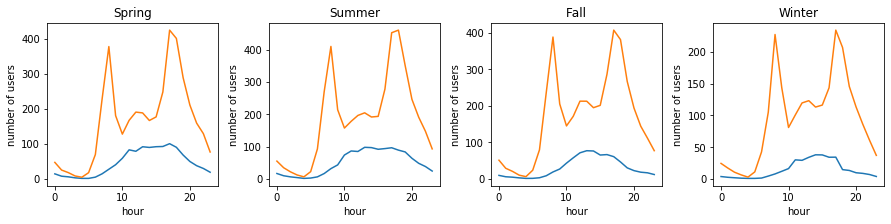

In [15]:
plt_spring = BSS_train[BSS_train["spring"] == 1].groupby("hour", as_index=False).agg(
    {'casual' : 'mean', 'registered' : 'mean'})
plt_summer = BSS_train[BSS_train["summer"] == 1].groupby("hour", as_index=False).agg(
    {'casual' : 'mean', 'registered' : 'mean'})
plt_fall = BSS_train[BSS_train["fall"] == 1].groupby("hour", as_index=False).agg(
    {'casual' : 'mean', 'registered' : 'mean'})
plt_winter = BSS_train[(BSS_train["spring"] == 0) & 
                       (BSS_train["summer"] == 0) & 
                       (BSS_train["fall"] == 0)].groupby("hour", as_index=False).agg({'casual' : 'mean', 'registered' : 'mean'})
plts = [plt_spring, plt_summer, plt_fall, plt_winter]

fig, ax = plt.subplots(1,4, figsize=(15, 3))
plt.subplots_adjust(wspace = 0.3)
sub_title = ['Spring', 'Summer', 'Fall', 'Winter']
count=0
for pt in plts:
    ax[count].plot(pt['hour'], pt['casual'], label='Casual')
    ax[count].plot(pt['hour'], pt['registered'], label='Registered')
    #ax[count].legend()
    ax[count].set_xlabel('hour')
    ax[count].set_ylabel('number of users')
    ax[count].set_title(sub_title[count])
    count+=1

*Answer:* Overall, we see a slight increase in maximimum usage from registered riders in the summer, and overall a sharp decrease in ridership at all hours during the winter for both registered and casual riders.

Season does not appear to drastically change the shape of the distribution of usage by registered riders by hour of day, even in the winter time. Instead, we just see less ridership overall by registered riders in the winter, but at similar peaks and valleys as other seasons (i.e. peaking at commuting hours).

Seasons do appear to impact the shape of the distribution of usage for casual riders. During the summer, we see higher rates of usage for later hours of the day than in other season. In winter, we see a sharp drop in usage for casual riders once evening hours set in. 

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [16]:
X_train = sm.add_constant(BSS_train.drop(['casual', 'registered', 'counts'], axis=1))
X_test = sm.add_constant(BSS_test.drop(['casual', 'registered', 'counts'], axis=1))
Y_train = BSS_train[['counts']]
Y_test = BSS_test[['counts']]

model = OLS(Y_train, X_train).fit()
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

r2_train = r2_score(Y_train, ypred_train)
r2_test = r2_score(Y_test, ypred_test)

print('Train R2: {} \n Test R2: {}'.format(r2_train, r2_test))


Train R2: 0.4115699822629326 
 Test R2: 0.40072109229413466


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 Examine the estimated coefficients and report...**

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:23:46   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [18]:
sig_vars = model.pvalues[model.pvalues < 0.05]
print('The statistically significant variables at \
significance level of 5% and their p-values are as follows: \
\n{}'.format(sig_vars))

The statistically significant variables at significance level of 5% and their p-values are as follows: 
const          5.319401e-03
hour          6.967036e-200
holiday        2.214061e-02
year          3.862196e-142
workingday     1.828978e-03
temp           9.243128e-06
atemp          1.229662e-02
hum            5.926590e-90
spring         1.510519e-07
summer         4.168321e-02
fall           6.554799e-14
Apr            3.897799e-04
May            2.023805e-04
Jun            1.392848e-07
Jul            3.606677e-09
Aug            1.084419e-04
Nov            6.623427e-03
Dec            4.454012e-02
Sat            2.255964e-02
Snow           1.092443e-05
dtype: float64


**3.3 You should see some strange estimates for the predictors representing months...** 

*Answers:* Controlling for all other predictors (including seasons and temperature), the number of riders per hour in July is on average 90.897 riders less than in January, which is the reference category.

This unexpected negative coefficient for July, in comparison to the reference category of January, likely occurs because we are controlling for the effect of predictors such as seasons and temperature. If we removed predictors that strongly correlated with the months variable, we would likely see that July in fact has a higher predicted number of riders per hour on average than January. 

**3.4 To diagnose the model, make two plots:...**

Text(0.5, 0, 'Predicted Y, training set')

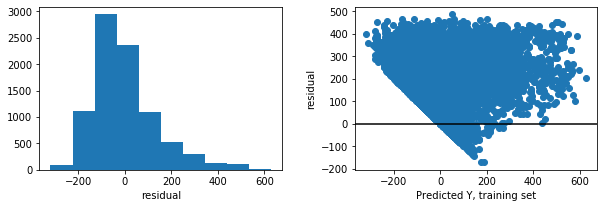

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
plt.subplots_adjust(wspace=0.3)

ax[0].hist(model.resid)
ax[0].set_xlabel("residual")
ax[1].scatter(model.resid, ypred_train)
ax[1].axhline(y=0, color='black')
ax[1].set_ylabel('residual')
ax[1].set_xlabel('Predicted Y, training set')

*Answer:* One of the assumptions we hold when using OLS is that our model's parameters are linear. 
What this means is that we assume that error terms (i.e. residuals) are homoscedastic (i.e. constant variance) and are normally distributed.

The first graph above shows that the residuals are not quite normally distributed, making us question the assumption of linearity.
The second graph further confirms our suspicions, because we see strong evidence for heteroscedasticity. In other words, the variance of residuals across different values of $\hat{y}$ is not constant. Instead, we see variance of residuals increasing (i.e. spreading out) as $\hat{y}$ increases. 

Thus, these plots reveal that we should strongly reconsider using a linear model for this data set.

**3.5 Perhaps we can do better via a model...**

In [20]:
# Section 4 2-degree polynomial code
def squaring(df, col_lst):
    df = df.copy()
    for col in col_lst:
        df['{}^2'.format(col)] = df[col]**2
    return df

col_lst = ['temp', 'hour', 'hum']

X_train_poly = squaring(X_train, col_lst)

model_poly = OLS(Y_train, X_train_poly).fit()
model_poly.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:23:49   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
temp^2       140.6804     46.276      3.040      0.002      49.968     231.393
hour^2        -1.3881      0.034    -40.654      0.000      -1.455      -1.321
hum^2       -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

*Answer:* While we are not sure at this point whether adding polynomial terms will improve the predictive power for our model (we have not done any cross-validation yet), we can say that the polynomial terms are at least statistically significant at the 5% significance level, and are thus important. 

For the temperature variable: Ridership rises at an increasingly fast rate as temperature rises (since $X$ term is positive and $X^2$ term is positive).

For hour: Ridership rises with hour at an increasingly slower rate, until around hour = 14.5 (2:30 PM), and then declines at an increasingly fast rate. 

For humidity: Ridership rises with humidity at an increasingly slower rate until around humidity = 0.17, and then declines at an increasingly fast rate. 

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [21]:
X_train_drop = X_train.drop(['workingday','atemp', 'spring', 'summer', 'fall'], axis=1)

model_drop = OLS(Y_train, X_train_drop).fit()
model_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:23:51   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Answer:* Yes, the estimates do seem to be more sensible. For example, our original model had days Monday through Thursday have negative coefficients in comparison to Sunday, whereas the drop model has positive coefficients for all weekdays in comparison to Sundays. 

Additionally, for months, we see a more sensible set of coefficients: On months during the school year, we see positive coefficients in comparison to January (reference category), while months during the summer and winter holidays have negative coefficients. 

Multicolinearity can lead to erroneous coefficient values because highly correlated independent variables are essentially trying to explain the same change in predicted value. In a linear regression, a per unit change in an independent variable explains an average change in our response variable, holding all other variables constant. But if we hold correlated variables constant, it is as if we are holding a part of our independent variable of interest constant. This throws off our estimations, since we cannot measure the independent effects of each variable on the response variable. 

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [22]:
BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
BSS_test= BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

In [23]:
#X_train = BSS_train.drop(['casual', 'registered', 'counts'], axis=1)
X_train.head()

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,fall,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,21,0,1,1,0.24,0.2273,0.60,0.2537,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,1.0,17,0,0,1,0.62,0.5758,0.83,0.2537,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,1.0,9,0,1,1,0.76,0.7273,0.66,0.1642,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1.0,17,0,1,0,0.62,0.6061,0.22,0.2985,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,8,0,1,0,0.18,0.1970,0.40,0.1343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**4.2 Write a function to standardize...**

In [24]:
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
#binary_columns = [ 'holiday','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

practice_X_train = X_train[X_train.columns.difference(binary_columns)]


def std_scale(x_train, x_test, binary_cols=[]): 
    scaled_train = x_train.copy()
    scaled_test = x_test.copy()
    
    nonbin = scaled_train.columns.difference(binary_cols)
    scaler = StandardScaler().fit(scaled_train[nonbin])
    
    scaled_train[nonbin] = scaler.transform(scaled_train[nonbin])
    scaled_test[nonbin] = scaler.transform(scaled_test[nonbin])
    
    '''    
    nonbin_train = x_train[nonbin]
    nonbin_test = x_test[nonbin]
    bin_train = x_train[binary_cols]
    bin_test = x_test[binary_cols]
    #print(nonbin_train.head())
    scaler = StandardScaler().fit(nonbin_train)
    
    scaled_train = scaler.transform(nonbin_train)  
    scaled_test = scaler.transform(nonbin_test)
    
    scaled_train_df = pd.DataFrame(scaled_train, columns = nonbin)
    scaled_test_df = pd.DataFrame(scaled_test, columns = nonbin)

    
    scaled_train = pd.concat([scaled_train_df, bin_train], axis=1, sort=False)
    scaled_test = pd.concat([scaled_test_df, bin_test], axis=1, sort=False)
'''
    return scaled_train, scaled_test

#x_train= X_train.drop(['const'], axis=1)
#x_test = X_test.drop(['const'], axis=1)
practice_X_train_scaled, test_scale_whatever = std_scale(x_train, x_train, binary_columns)
practice_X_train_scaled.describe()


NameError: name 'x_train' is not defined

**4.3 Write code to augment your a dataset with higher-order features for...**

In [793]:
'''
def higher_power(x_train, x_test, cols, degrees):
    x_train1 = x_train.copy()
    x_test1 = x_test.copy()
    for degree in range(2,degrees+1):
        for col in cols:
            x_train['{}^{}'.format(col, degree)] = x_train[col]**degree
            x_test['{}^{}'.format(col, degree)] = x_test[col]**degree
    return (x_train1, x_test1)
'''
def higher_power(x_train, cols, degrees):
    x_train1 = x_train.copy()
    for degr in range(2,degrees+1):
        for col in cols:
            x_train1['{}^{}'.format(col, degr)] = x_train1[col]**degr
    return (x_train1)

poly_col = ['temp', 'hum', 'windspeed', 'hour']

practice_X_train_poly = higher_power(practice_X_train_scaled, poly_col, 3)
#practice_X_train_poly = results[0]

print(practice_X_train_poly.columns)
practice_X_train_poly.head()



Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2', 'hum^2',
       'windspeed^2', 'hour^2', 'temp^3', 'hum^3', 'windspeed^3', 'hour^3'],
      dtype='object')


,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,fall,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,temp^2,hum^2,windspeed^2,hour^2,temp^3,hum^3,windspeed^3,hour^3
0,1.350966,0,0.993233,1,-1.331629,-1.442584,-0.131358,0.511860,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1.773236,0.017255,0.262001,1.825110,-2.361293,-0.002267,0.134108,2.465662
1,0.776238,0,-1.006813,1,0.641888,0.583783,1.064879,0.511860,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.412021,1.133967,0.262001,0.602545,0.264471,1.207537,0.134108,0.467718
2,-0.373220,0,0.993233,1,1.368974,1.464686,0.180704,-0.214334,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1.874089,0.032654,0.045939,0.139293,2.565579,0.005901,-0.009846,-0.051987
3,0.776238,0,0.993233,0,0.641888,0.759963,-2.107748,0.875363,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.412021,4.442601,0.766260,0.602545,0.264471,-9.363882,0.670755,0.467718
4,-0.516902,0,0.993233,0,-1.643237,-1.618765,-1.171563,-0.456939,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.700228,1.372560,0.208794,0.267188,-4.437116,-1.608040,-0.095406,-0.138110


**4.4 Write code to add interaction terms to the model...**

In [794]:
def interaction(x_train, cont_lst, dummy_lst):
    x_set = x_train.copy()
    for contin in cont_lst:
        for dummy in dummy_lst:
            x_set['{}*{}'.format(contin, dummy)] = x_set[contin]*x_set[dummy]
    return x_set

cont_lst = ['temp', 'hum', 'windspeed']
dummy_lst = ['Feb', 'Mar', 'Apr', "May", 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

practice_X_train_interact = interaction(practice_X_train_poly, cont_lst, dummy_lst)

print(practice_X_train_interact.columns)
practice_X_train_interact.head()

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2', 'hum^2',
       'windspeed^2', 'hour^2', 'temp^3', 'hum^3', 'windspeed^3', 'hour^3',
       'temp*Feb', 'temp*Mar', 'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul',
       'temp*Aug', 'temp*Sept', 'temp*Oct', 'temp*Nov', 'temp*Dec', 'temp*Mon',
       'temp*Tue', 'temp*Wed', 'temp*Thu', 'temp*Fri', 'temp*Sat', 'hum*Feb',
       'hum*Mar', 'hum*Apr', 'hum*May', 'hum*Jun', 'hum*Jul', 'hum*Aug',
       'hum*Sept', 'hum*Oct', 'hum*Nov', 'hum*Dec', 'hum*Mon', 'hum*Tue',
       'hum*Wed', 'hum*Thu', 'hum*Fri', 'hum*Sat', 'windspeed*Feb',
       'windspeed*Mar', 'windspeed*Apr', 'windspeed*May', 'windspeed*Jun',
       'windspeed*Jul', 'windspeed*Aug', 'windspeed*Sept', 'windspeed*Oct',
       'windspeed*Nov

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,fall,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,temp^2,hum^2,windspeed^2,hour^2,temp^3,hum^3,windspeed^3,hour^3,temp*Feb,temp*Mar,temp*Apr,temp*May,temp*Jun,temp*Jul,temp*Aug,temp*Sept,temp*Oct,temp*Nov,temp*Dec,temp*Mon,temp*Tue,temp*Wed,temp*Thu,temp*Fri,temp*Sat,hum*Feb,hum*Mar,hum*Apr,hum*May,hum*Jun,hum*Jul,hum*Aug,hum*Sept,hum*Oct,hum*Nov,hum*Dec,hum*Mon,hum*Tue,hum*Wed,hum*Thu,hum*Fri,hum*Sat,windspeed*Feb,windspeed*Mar,windspeed*Apr,windspeed*May,windspeed*Jun,windspeed*Jul,windspeed*Aug,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,1.350966,0,0.993233,1,-1.331629,-1.442584,-0.131358,0.511860,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1.773236,0.017255,0.262001,1.825110,-2.361293,-0.002267,0.134108,2.465662,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-1.331629,-0.0,-0.0,-0.0,-1.331629,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.131358,-0.0,-0.0,-0.0,-0.131358,-0.0,-0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.51186,0.0,0.0,0.0,0.511860,0.0,0.0
1,0.776238,0,-1.006813,1,0.641888,0.583783,1.064879,0.511860,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.412021,1.133967,0.262001,0.602545,0.264471,1.207537,0.134108,0.467718,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.641888,0.0,0.000000,0.0,0.0,0.0,0.641888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.064879,0.0,0.000000,0.0,0.0,0.0,1.064879,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.51186,0.0,0.00000,0.0,0.0,0.0,0.511860,0.0,0.0
2,-0.373220,0,0.993233,1,1.368974,1.464686,0.180704,-0.214334,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1.874089,0.032654,0.045939,0.139293,2.565579,0.005901,-0.009846,-0.051987,0.0,0.0,0.000000,0.0,0.0,0.0,1.368974,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.368974,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.180704,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.180704,0.0,0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.214334,-0.0,-0.00000,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.214334,-0.0,-0.0
3,0.776238,0,0.993233,0,0.641888,0.759963,-2.107748,0.875363,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.412021,4.442601,0.766260,0.602545,0.264471,-9.363882,0.670755,0.467718,0.0,0.0,0.641888,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,-2.107748,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,0.0,0.0,0.875363,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,-0.516902,0,0.993233,0,-1.643237,-1.618765,-1.171563,-0.456939,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.700228,1.372560,0.208794,0.267188,-4.437116,-1.608040,-0.095406,-0.138110,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.00000,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [795]:
print(BSS_train.shape)
BSS_test.head()

(8689, 29)


,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0.26,0.48,0.2985,0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0.36,0.71,0.1343,29,110,139,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,12,0,1,0.36,0.53,0.4478,13,213,226,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
3,0,0,1,0.28,0.65,0.0896,4,39,43,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0.60,0.88,0.1642,31,99,130,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [803]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'casual', 'registered']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # add code here 
    y_train = train_df[['counts']]
    y_val =  val_df[['counts']]
    
    train_df = train_df.drop(bad_columns, axis=1)
    test_df = val_df.drop(bad_columns, axis=1)
    
    bin_columns = ['holiday','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
    train_scaled, test_scaled = std_scale(train_df, test_df, bin_columns)
    #train_scaled = train_df
    #test_scaled = test_df
    y_train, y_val = std_scale(y_train, y_val)
    
    if degree > 1:
        train_pol = higher_power(train_scaled, cols=columns_forpoly, degrees=degree)
        test_pol = higher_power(test_scaled, cols=columns_forpoly, degrees=degree)

    else:
        train_pol = train_scaled
        test_pol = test_scaled
    
    x_train = interaction(train_pol, cont_lst, dummy_lst)
    x_test = interaction(test_pol, cont_lst, dummy_lst)
    
    return x_train, x_test, y_train,y_val

X_train, X_test, y_train, y_test = get_design_mats(BSS_train, BSS_test, 3)

print(y_train.mean(), y_test.mean())
X_test[X_test.isnull().any(axis=1)]

print(BSS_train.shape)
print(BSS_test.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

counts    7.902784e-17
dtype: float64 counts   -0.010124
dtype: float64
(8689, 29)
(8690, 29)
(8689, 85)
(8690, 85)
(8689, 1)
(8690, 1)


**4.6 For each degree in 1 through 8...**

In [797]:
models=[]
R2_tests=[]

for deg in [1,2,3,4,5,6,7,8,10,12,15,18,20]:
    X_train, X_test, y_train, y_test= get_design_mats(BSS_train, BSS_test, deg)

    X_train_reshape = sm.add_constant(X_train)
    X_test_reshape = sm.add_constant(X_test)
    
    model = OLS(np.array(y_train).reshape(-1,1), X_train_reshape).fit()
    models.append(model)
    ypred = model.predict(X_train_reshape)
    
    R2_tests.append(r2_score(y_train, ypred))
    
    ypred = model.predict(X_test_reshape)
    R2_tests.append(r2_score(y_test, ypred))
    R2_tests.append(deg)

(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(8689, 1)
(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [798]:
'''
model = OLS(y_trains[7], sm.add_constant(X_trains[7])).fit()

ypred = model.predict(sm.add_constant(X_tests[7]))
ypred.head()
r2_score(y_tests[7], ypred)
'''
R2_tests

[0.43748233128279357,
 0.42919370152715897,
 1,
 0.5263508465227291,
 0.5121988354655902,
 2,
 0.5695700518891642,
 0.561270547555935,
 3,
 0.5713803510887172,
 0.5643812587064096,
 4,
 0.5863107566121699,
 0.5760635265312029,
 5,
 0.6088187790814179,
 0.5990042016659349,
 6,
 0.647858004410737,
 0.6337668811583963,
 7,
 0.6572181202880106,
 0.6433746024489525,
 8,
 0.6662429373405028,
 0.6491387617184334,
 10,
 0.6746618012544814,
 0.6555718973234912,
 12,
 0.7119408124710986,
 0.6866433320557452,
 15,
 0.7114681072105462,
 0.6862317589498206,
 18,
 0.6795800398991982,
 0.5848499133769084,
 20]

**4.7 Discuss patterns you see in the results...**

*your answer here*

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [804]:
ridge_train, ridge_val = train_test_split(BSS_train, train_size=0.8)
ridge_train.head()

,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
3594,7,0,0,0.68,0.83,0.1940,27,320,347,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8240,10,0,0,0.64,0.83,0.0000,85,190,275,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2144,20,0,0,0.32,0.45,0.1940,6,146,152,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
6776,14,0,0,0.56,0.46,0.1045,32,129,161,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4926,0,0,1,0.40,0.43,0.1343,1,32,33,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [820]:
ridge_models=[]
ridge_R2s=[]

alphas = [.01,.05,.1,.5,1,5,10,50,100]


#print(ridge_xtrain[ridge_xtrain.isnull().any(axis=1)])

for degree in range(1, 9):
    ridge_xtrain, ridge_xtest, ridge_ytrain, ridge_ytest=get_design_mats(ridge_train, ridge_val, degree)
    alpha_ridge_R2s=[]
    alpha_ridge_models=[]
    print(ridge_xtest.shape)
    
    for alpha in alphas:
        ridge_model = Ridge(alpha=alpha).fit(ridge_xtrain, ridge_ytrain)
        alpha_ridge_models.append(ridge_model)
        alpha_ridge_R2s.append(ridge_model.score(ridge_xtest,ridge_ytest))
    ridge_R2s.append(alpha_ridge_R2s)
    ridge_models.append(alpha_ridge_models)
    
R2_df = pd.DataFrame(ridge_R2s, columns=alphas)
ridge_df = pd.DataFrame(ridge_models, columns=alphas)
R2_df

(1738, 77)
(1738, 81)
(1738, 85)
(1738, 89)
(1738, 93)
(1738, 97)
(1738, 101)
(1738, 105)


,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0
0,0.431503,0.431516,0.431531,0.431627,0.431706,0.431882,0.431960,0.431907,0.430901
1,0.520568,0.520582,0.520600,0.520709,0.520795,0.520927,0.520900,0.520638,0.519947
2,0.568201,0.568204,0.568207,0.568232,0.568265,0.568544,0.568838,0.568880,0.566682
3,0.569052,0.569052,0.569052,0.569054,0.569060,0.569151,0.569262,0.568429,0.565590
4,0.581705,0.581705,0.581705,0.581710,0.581718,0.581842,0.582033,0.582354,0.581256
5,0.596824,0.596838,0.596856,0.596994,0.597160,0.598198,0.598932,0.597777,0.594293
6,0.635640,0.635674,0.635714,0.635986,0.636210,0.635397,0.632113,0.612439,0.601578
7,0.639973,0.640098,0.640247,0.641165,0.641794,0.639417,0.633390,0.609640,0.599936


**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
# your code here

**5.3 It's time to see how well our selected model...**


In [822]:
best_model = ridge_df.iloc[7,4]

xtrain8, xtest8, ytrain8, ytest8=get_design_mats(BSS_train, BSS_test, 8)

test_best_R2 = best_model.score(xtest8, ytest8)
print("The best selected model's test R2: {}".format(test_best_R2))

The best selected model's test R2: 0.6410894362363291


**5.4 Build a dataset with polynomial degree 1...**

In [878]:
q5_trainx, q5_testx, q5_trainy, q5_testy=get_design_mats(BSS_train, BSS_train, 1)

print(q5_trainy.shape)

#OLSmodel = OLS(sm.add_constant(q5_trainx), q5_trainy)
OLSmodel = OLS(q5_trainy, sm.add_constant(q5_trainx)).fit()

alphas = [.1, .5, 1, 5, 10, 50, 100]
q5_trainy = q5_trainy['counts']

#section 4 code
fitted_ridge = RidgeCV(alphas=alphas, cv = 5).fit(q5_trainx, q5_trainy)
ridge_a = fitted_ridge.alpha_
fitted_lasso = LassoCV(alphas=alphas, cv=5, max_iter=100000).fit(q5_trainx, q5_trainy)
lasso_a = fitted_ridge.alpha_

print("Best Ridge alpha: {} \n Best LASSO alpha: {}".format(ridge_a, lasso_a))

OLSmodel.summary()

(8689, 1)


C:\Users\davidsong\Anaconda3\envs\109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Best Ridge alpha: 1.0 
 Best LASSO alpha: 1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     86.97
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:12:19   Log-Likelihood:                -9829.6
No. Observations:                8689   AIC:                         1.982e+04
Df Residuals:                    8611   BIC:                         2.037e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3351      0.085     -3.923      0.000      -0.503      -0.168
hour               0.2711      0.009     30.789      0.000       0.254       0.288
holiday           -0.1792      0.051     -3.501      0.000      -0.280      -0.079
year               0.2083      0.009     24.184      0.000       0.191       0.225
temp               0.2821      0.060      4.664      0.000       0.164       0.401
hum               -0.1636      0.039     -4.152      0.000      -0.241      -0.086
windspeed         -0.0530      0.038     -1.401      0.161      -0.127       0.021
Feb                0.0126      0.107      0.118      0.906      -0.197       0.223
Mar                0.3894      0.091      4.284      0.000       0.211       0.568
Apr                0.3742      0.089      4.209      0.000       0.200       0.548
May                0.3000      0.095      3.160      0.002       0.114       0.486
Jun                0.2796      0.107      2.605      0.009       0.069       0.490
Jul                0.3452      0.160      2.153      0.031       0.031       0.660
Aug                0.0767      0.150      0.513      0.608      -0.216       0.370
Sept               0.4581      0.099      4.627      0.000       0.264       0.652
Oct                0.6657      0.088      7.547      0.000       0.493       0.839
Nov                0.5623      0.097      5.807      0.000       0.373       0.752
Dec                0.4889      0.106      4.621      0.000       0.282       0.696
Mon                0.0413      0.032      1.303      0.193      -0.021       0.103
Tue                0.0688      0.031      2.196      0.028       0.007       0.130
Wed                0.0416      0.031      1.338      0.181      -0.019       0.102
Thu                0.0362      0.031      1.175      0.240      -0.024       0.097
Fri                0.0809      0.031      2.629      0.009       0.021       0.141
Sat                0.0588      0.030      1.931      0.053      -0.001       0.119
Cloudy             0.0319      0.020      1.593      0.111      -0.007       0.071
Snow              -0.1508      0.034     -4.497      0.000      -0.216      -0.085
Storm              0.0773      0.539      0.144      0.886      -0.979       1.134
temp*Feb          -0.0300      0.081     -0.371      0.711      -0.189       0.128
temp*Mar           0.3112      0.072      4.311      0.000       0.170       0.453
temp*Apr           0.3353      0.079      4.250      0.000       0.181       0.490
temp*May           0.3088      0.083      3.716      0.000       0.146       0.472
temp*Jun           0.0696      0.089      0.780      0.435      -0.105       0.245
temp*Jul          -0.0663      0.118     -0.564      0.573      -0.297       0.164
temp*Aug           0.2909      0.120      2.432      0.015       0.056       0.525
temp*Sept   

**5.5 Plot histograms of the coefficients found...**

(77,)
(77,)


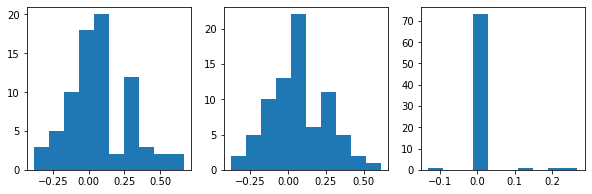

In [886]:
OLSbetas = OLSmodel.params
#drop constant to compare w/ ridge and LASSO betas
OLSbetas = OLSbetas.iloc[1:]
print(OLSbetas.shape)

ridgeBetas = fitted_ridge.coef_

lassoBetas = fitted_lasso.coef_

fig, ax = plt.subplots(1,3, figsize=(10, 3));
ax[0].hist(OLSbetas)
ax[1].hist(ridgeBetas)
ax[2].hist(lassoBetas)



In [887]:
print(OLSbetas.shape)
print(ridgeBetas.shape)
print(lassoBetas.shape)

print(OLSbetas.head())
print(ridgeBetas)
print(lassoBetas)

(77,)
(77,)
(77,)
hour       0.271113
holiday   -0.179226
year       0.208281
temp       0.282133
hum       -0.163624
dtype: float64
[ 0.27095606 -0.17840058  0.20760793  0.31824308 -0.1669257  -0.057357
 -0.04045166  0.33394853  0.31884065  0.24532565  0.22372646  0.2765881
  0.02451727  0.40301941  0.61016348  0.50413036  0.42928655  0.04160045
  0.06853304  0.0417987   0.03593567  0.08059962  0.05878575  0.0319466
 -0.15034845  0.06182758 -0.06577233  0.27306459  0.29657765  0.2715326
  0.03395256 -0.09253689  0.2519134   0.32287915  0.2922208   0.30751778
  0.27004743 -0.1221363  -0.13462369 -0.07838261 -0.13709701 -0.11878401
 -0.02302967  0.03493039  0.02233203 -0.08013791 -0.21840537 -0.18088478
 -0.22629496 -0.2712414  -0.37465119 -0.29534974 -0.1775345  -0.09714522
  0.09611106  0.10654585  0.12217783  0.13165817  0.12908146 -0.02532907
  0.00757959  0.04447795  0.03137698  0.07835945  0.14283775  0.1818839
  0.09990288  0.09236395  0.07106006 -0.00457508 -0.05426665 -0.010336

**5.6 The plots above show the overall distribution of...**

In [ ]:
N = 78
fig, ax = plt.subplots()
ind = np.arrange(N)
width = 0.35
p1 = ax.bar(ind, OLSbetas, width, bottom=0*cm)



**5.7 What trends do you see...**

In [ ]:
# your code here

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*